# CE888 Assignment
## Project: Empathy

__Dataset information__<br>
60 participants <br>
502 .csv files of eye gaze recordings of 60 participants in different number of trailas


__Data divided into datasets:__<br>
- IA with questionaries answers before intervention
- IB with questionaries answers after intervention
- II with gaze recording data of participants in control group performing free exploration of structureless images
- III with gaze recording data of participants in test group performing a task consisting of gaze typing, i.e. writing sentences using eye-gaze movements on a card board

__Empathy assessment__<br>
Two questionnaires called _questionnaire of cognitive and affective empathy_. <br>
Answerts and results stored in datasets IA and IB, which contains an original and extended empathy scores of each participant. <br>
According to the authors, the pupils dilate when a person feels empathy.<br>
The pupil dilation during the fixation movement of the eye might be used for empathy assessment.<br>
The empathy score of the participant from the questionaries could be the desired output/target.<br>


__Project objective__ <br>
Based on the eye tracking data determine the empathy score of the participant.

__Loading libraries__

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import re
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score

from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error


__Creating necesarry methods__

In [2]:
def eye_movement_to_int(row):
   if row['Eye movement type'] == 'Unclassified':
      return 1
   if row['Eye movement type'] == 'EyesNotFound':
      return 1
   if row['Eye movement type'] == 'Saccade' :
      return 2
   if row['Eye movement type'] == 'Fixation' :
      return 3
   return 1

def sort(s):
   return list(map(int, re.findall(r'\d+', s)))

def fix_right_based_on_left(left, right):
   if np.isnan(right) and ~np.isnan(left): 
      return left
   else:
      return right

def fix_left_based_on_right(left, right):
   if np.isnan(left) and ~np.isnan(right): 
      return right
   else:
      return left

__Loading input data and preprocessing__ <br>
Each file from dataset in separate data-frame.

In [3]:
# Making sure each file is loaded into the program in order
#group = 'control'
group = 'test'
#group = 'all'

path = '/Users/o.golebiowska/VSC/CE888Assignment/EyeT/'

eye_path = path + group
eye_filenames = glob.glob(os.path.join(eye_path, "*.csv"))

eye_filenames.sort(key = sort)

participants_dfs = []

for filename in eye_filenames:
    df = (pd.read_csv(filename))

    features = [ 
        'Participant name', 
        'Recording timestamp',
        'Event', 
        'Pupil diameter left', 
        'Pupil diameter right', 
        'Eye movement type',
    ]
    df = df[features]

    for column in df.columns:
        if df[column].dtype == object and df[column].str.contains(',').any():
            df[column] = pd.to_numeric(df[column].str.replace(',', '.'), errors='coerce')
    
    df['Participant name'] = pd.to_numeric(df['Participant name'].str.replace('Participant00', ''), errors='coerce')
    
    df['Eye movement type'].fillna('Unclassified', inplace=True)
    df['Eye movement type'].fillna('EyesNotFound', inplace=True)

    # Change column with numeric label for the eye movement type
    df['Eye movement type'] = df.apply(lambda row: eye_movement_to_int(row), axis=1)

    df['Pupil diameter left'] = df.apply(lambda x: fix_left_based_on_right(x['Pupil diameter left'], x['Pupil diameter right']), axis = 1 )
    df['Pupil diameter right'] = df.apply(lambda x: fix_right_based_on_left(x['Pupil diameter left'], x['Pupil diameter right']), axis = 1 )

    df['Pupil diameter left'].fillna(method='ffill', inplace=True)
    df['Pupil diameter right'].fillna(method='ffill', inplace=True)

    df['Pupil_diameter_mean'] = (df['Pupil diameter left'] + df['Pupil diameter right'])/2
    df['Pupil_diameter_difference'] = abs((df['Pupil diameter left'] - df['Pupil diameter right']))
    df['Pupil_diameter_p'] = df['Pupil_diameter_difference']/df['Pupil_diameter_mean']
    
    participants_dfs.append(df)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (31,32,33,34,35,41,42,43,46,47,48,49,50,51,52,53,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Colum

Considering in each file there was more than one attepmt recorded, the recordings of each participant were concateneted together into one dataframe. resulting in a list of dataframes per participant with all of their attepmts in one dataframe.

In [4]:
# Create an empty dictionary to store the dataframes for each participant
participant_dfs_dict = {}

# Loop through each dataframe, and group them by participant
for df in participants_dfs:
    participant_number = df['Participant name'].iloc[0]

    if participant_number not in participant_dfs_dict:
        participant_dfs_dict[participant_number] = [df]
    else:
        participant_dfs_dict[participant_number].append(df)

participants = []
# For each participant, concatenate their dataframes along the columns
for participant, dfs in participant_dfs_dict.items():
    combined = pd.concat(dfs)
    participants.append(combined)

__Loading the output data__ <br>
Considering only the extended empathy score.

In [5]:
columns = ['Participant nr','Total Score extended']

emp_before = pd.read_csv('/Users/o.golebiowska/VSC/CE888Assignment/questionaries/Questionnaire_datasetIA.csv', encoding='unicode_escape', usecols=columns, dtype={'Participant nr' : str})
emp_after = pd.read_csv('/Users/o.golebiowska/VSC/CE888Assignment/questionaries/Questionnaire_datasetIB.csv', encoding='unicode_escape', usecols=columns, dtype={'Participant nr' : str})

In [6]:
# Adding the empathy scores column to each participant dataframe
for p in participants:
    p_no =str(p['Participant name'].iloc[0])
    p['empathy_before_ext'] = emp_before['Total Score extended'].loc[emp_before['Participant nr'] == p_no].iloc[0]
    p['empathy_after_ext'] = emp_after['Total Score extended'].loc[emp_before['Participant nr'] == p_no].iloc[0]

__Further processing__

In [7]:
# Creating new dataframe with summary of all attempts per participant
options = ['ImageStimulusStart', 'ImageStimulusEnd']
df = pd.DataFrame()

for p_df in participants:
    attempt = 0
    participant_no = str(int(float(p_df['Participant name'].iloc[0])))

    df_start_stop = p_df.loc[p_df['Event'].isin(options)]
    df_attempts = df_start_stop[['Recording timestamp','Event']]
    df_attempts.reset_index(drop=True, inplace=True)

    for i in range(0,len(df_attempts),2):
        attempt = attempt + 1
        start = df_attempts.iloc[i]['Recording timestamp']
        stop = df_attempts.iloc[i+1]['Recording timestamp']

        empathy_before_ext = p_df['empathy_before_ext'].iloc[0]
        empathy_after_ext =  p_df['empathy_after_ext'].iloc[0]
            
        empathy_difference =  empathy_after_ext - empathy_before_ext
        empathy_mean = ((empathy_before_ext + empathy_after_ext)/2)
            
        timeseries = p_df[p_df['Recording timestamp'].between(start, stop, inclusive='neither')]
        timeseries['Index'] = range(1, len(timeseries) + 1)
            
        timeseries_mean = timeseries['Pupil_diameter_mean'].mean()
        timeseries_std = timeseries['Pupil_diameter_mean'].std()
            
        no_saccades = len(timeseries[timeseries['Eye movement type'] == 2])
        no_fixations = len(timeseries[timeseries['Eye movement type'] == 3])
        no_all_events = len(timeseries['Eye movement type'])
            
        fraction_saccades = no_saccades/no_all_events
        fraction_fixations = no_fixations/no_all_events
            
        new_record = {
                'participant_no'           : participant_no,
                'attempt_no'               : attempt,
                'attempt_pupil_size_mean'  : timeseries_mean,
                'attempt_pupil_size_std'   : timeseries_std,
                'no_saccades'              : no_saccades,
                'no_fixations'             : no_fixations,
                'fraction_saccades'        : fraction_saccades,
                'fraction_fixations'       : fraction_fixations,
                'empathy_before'           : empathy_before_ext,
                'empathy_after'            : empathy_after_ext,
                'empathy_difference'       : empathy_difference,
                'empathy_mean'             : int(empathy_mean)
            }
            
        df = df.append(new_record, ignore_index = True)
        if attempt == 4:
            break
    

/var/folders/g0/mw8m90vn5_d812g40__vqmd40000gn/T/ipykernel_976/4217091701.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeseries['Index'] = range(1, len(timeseries) + 1)


In [8]:
df.head()

,participant_no,attempt_no,attempt_pupil_size_mean,attempt_pupil_size_std,no_saccades,no_fixations,fraction_saccades,fraction_fixations,empathy_before,empathy_after,empathy_difference,empathy_mean
0,1,1.0,3.017128,0.133853,73794.0,171258.0,0.254490,0.590610,134.0,137.0,3.0,135.0
1,1,2.0,3.016717,0.136079,79074.0,185196.0,0.254608,0.596306,134.0,137.0,3.0,135.0
2,1,3.0,3.013295,0.135778,77736.0,177996.0,0.258592,0.592112,134.0,137.0,3.0,135.0
3,1,4.0,3.014399,0.135569,103974.0,234084.0,0.258503,0.581986,134.0,137.0,3.0,135.0
4,3,1.0,2.986486,0.253466,69380.0,71225.0,0.331668,0.340488,116.0,123.0,7.0,119.0


In [9]:
# Transforming object columns values to numeric
for column in df.columns:
        if df[column].dtype == object:
            df[column] = pd.to_numeric(df[column], errors='coerce')

/var/folders/g0/mw8m90vn5_d812g40__vqmd40000gn/T/ipykernel_976/380949603.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(15,5))


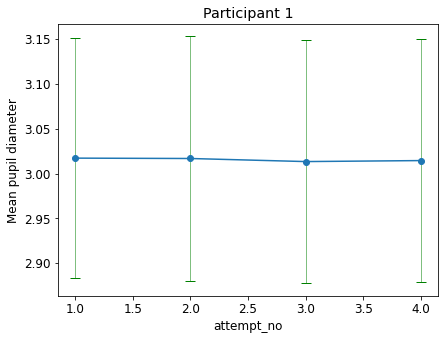

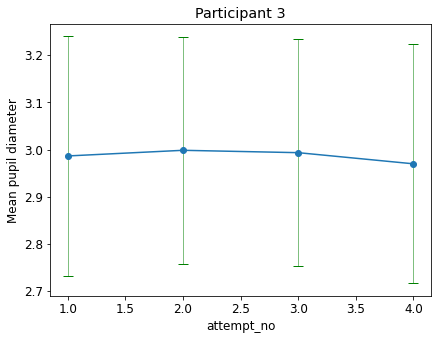

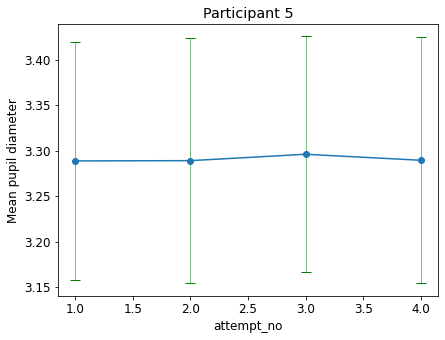

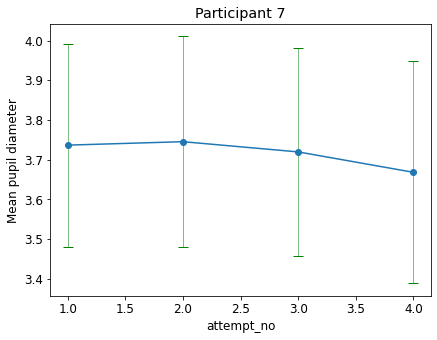

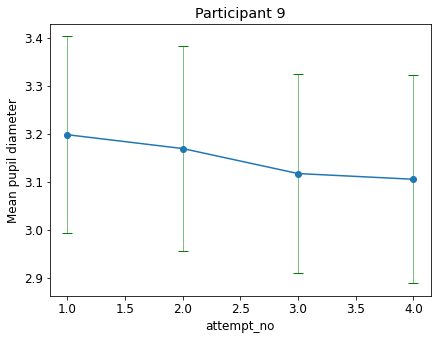

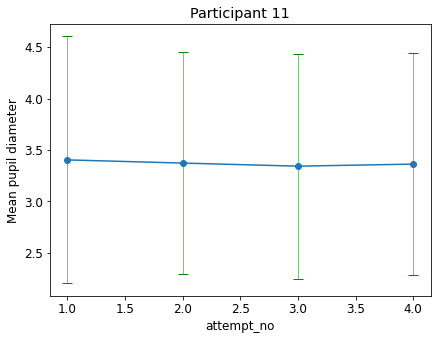

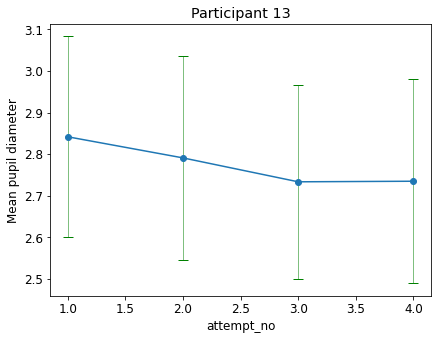

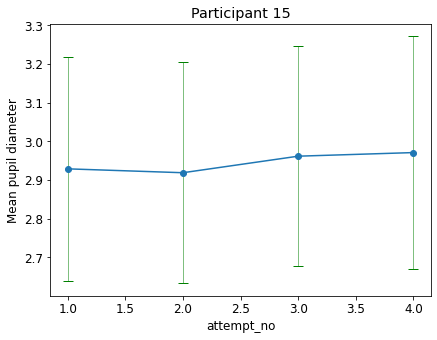

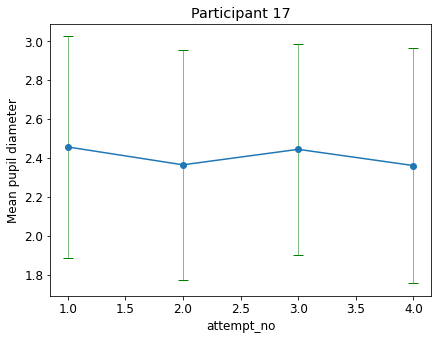

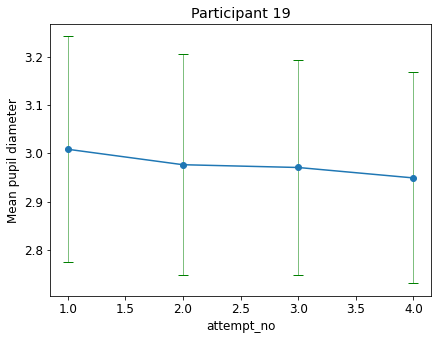

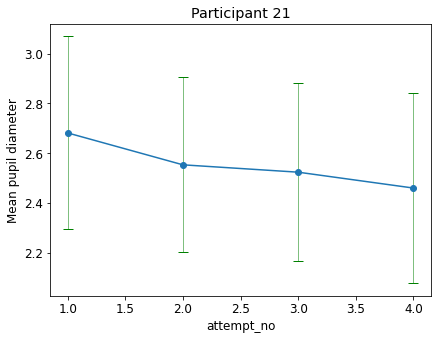

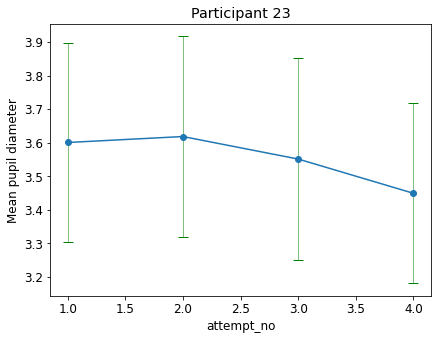

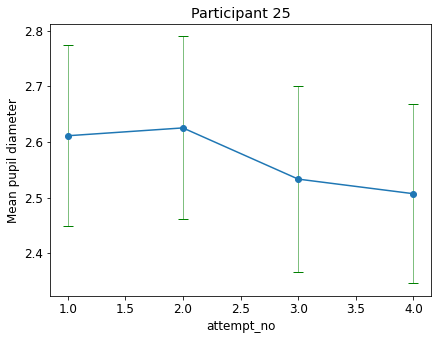

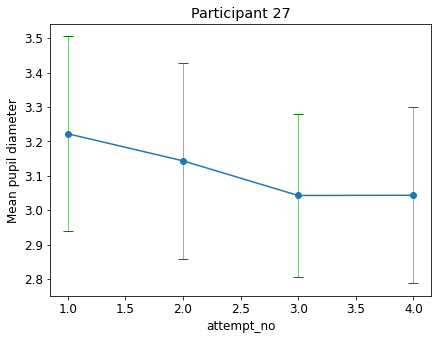

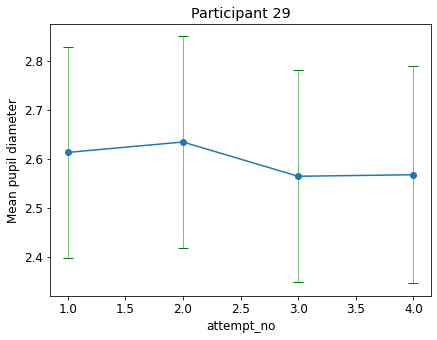

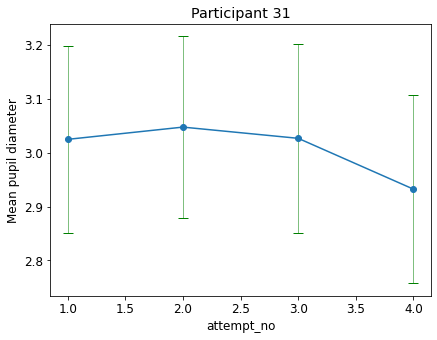

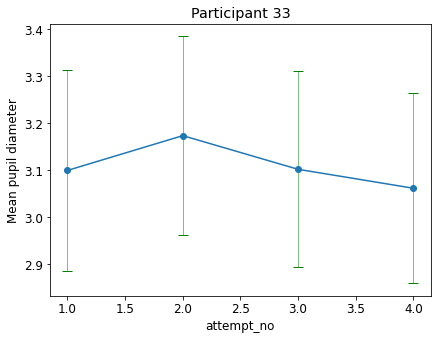

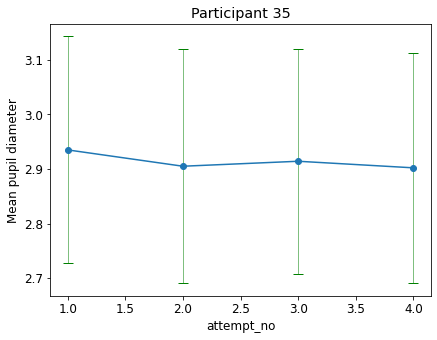

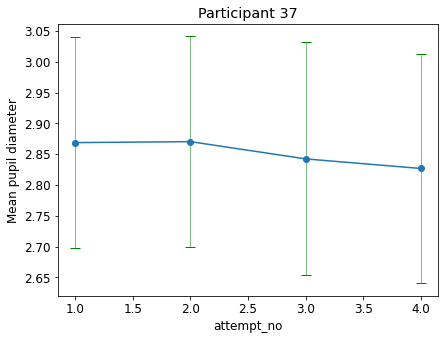

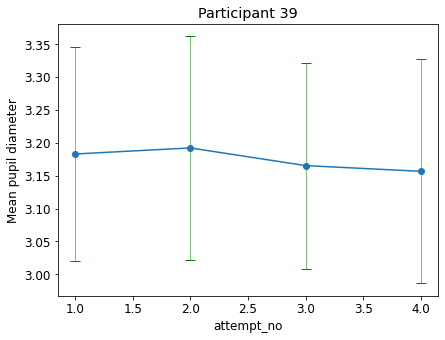

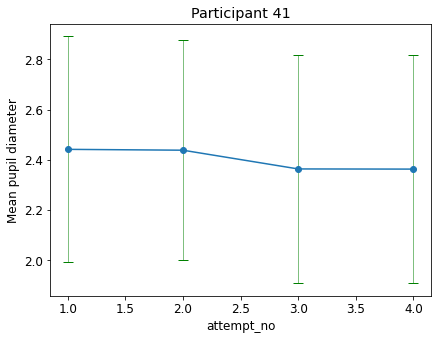

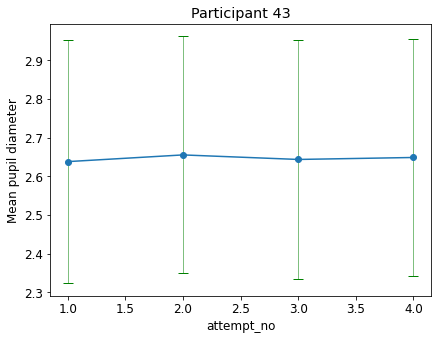

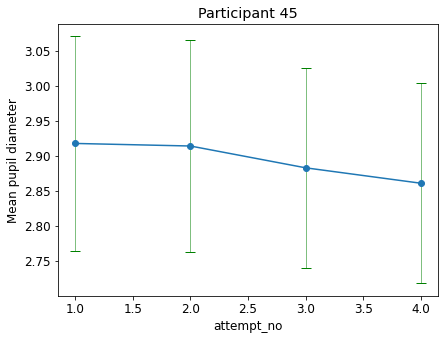

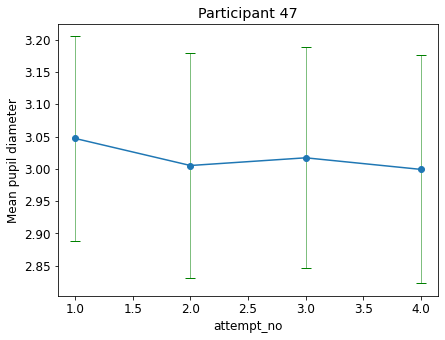

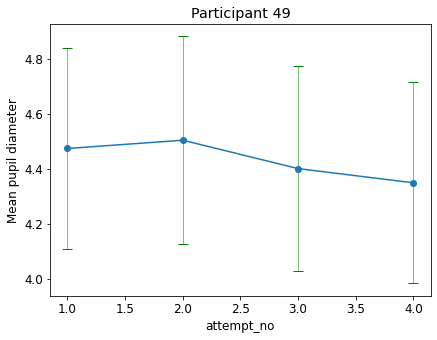

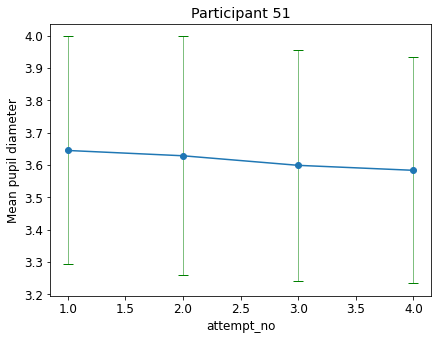

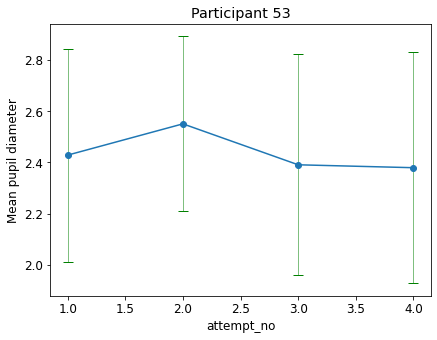

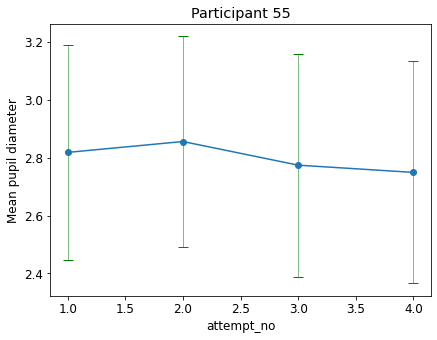

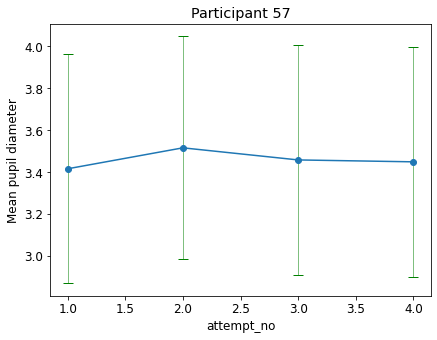

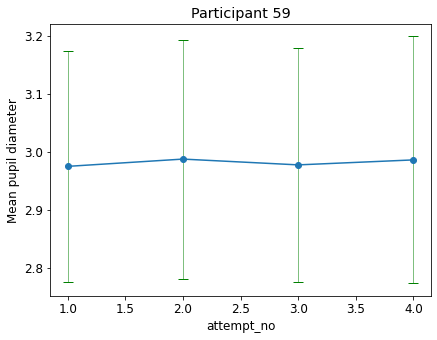

In [10]:
font = {'size':12}
plt.rc('font', **font)
i= 0
for key, group in df.groupby('participant_no'):
    i = i+1
    fig=plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    plt.xlabel("attempt_no")
    plt.ylabel("Mean pupil diameter")
    plt.title('Participant ' + str(key))
    plt.errorbar(group['attempt_no'], group['attempt_pupil_size_mean'], group['attempt_pupil_size_std'], linestyle='-', marker='o', capsize=5, ecolor="green", elinewidth = 0.5)

In [11]:
# Feature selection for input and output values for the model
features = ['attempt_pupil_size_mean',
            'attempt_pupil_size_std',
            'no_saccades',
            'no_fixations',
            'fraction_fixations',
            'fraction_saccades']

df_X = df[features]
df_y = df['empathy_mean']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.25, random_state=50, stratify = df_y.values)

__Models__

In [13]:
est2 = RandomForestRegressor(n_estimators = 350, random_state = 20)
est2.fit(X_train, y_train)
print("MSE of the model = %1.4g" % mse(y_train, est2.predict(X_train)))

MSE of the model = 5.731


In [14]:
est1 = DecisionTreeRegressor()
est1.fit(X_train, y_train)
print("MSE of the model = %1.4g" % mse(y_train, est1.predict(X_train)))

MSE of the model = 0


In [15]:
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)
print("MSE of the model = %1.4g" % mse(y_train, regressor.predict(X_train)))

MSE of the model = 99.77


In [16]:
reg = GradientBoostingRegressor(n_estimators=200)
reg.fit(X_train, y_train)
print("MSE of the model = %1.4g" % mse(y_train, reg.predict(X_train)))

MSE of the model = 0.02564


Testing: Decision Tree Regressor

In [17]:
# Assuming y_test and y_pred are your test output and predicted output, respectively
y_pred = est1.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(est1, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
mse_cv = -scores.mean()

def adjusted_r2_score(n, p):
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    return adj_r2

adj_r2 = adjusted_r2_score(len(y_test), X_test.shape[1])

print("MAE: {:.2f}".format(mae))
print("R^2: {:.2f}".format(r2))
print("MSE (cross-validation): {:.2f}".format(mse_cv))
print("Adjusted R-squared Score: {:.2f}".format(adj_r2))

MAE: 5.57
R^2: -0.05
MSE (cross-validation): 56.28
Adjusted R-squared Score: -0.32


Testing: Gradient Boosting Regressor

In [18]:
# Assuming y_test and y_pred are your test output and predicted output, respectively
y_pred = reg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(reg, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
mse_cv = -scores.mean()

def adjusted_r2_score(n, p):
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    return adj_r2

adj_r2 = adjusted_r2_score(len(y_test), X_test.shape[1])

print("MAE: {:.2f}".format(mae))
print("R^2: {:.2f}".format(r2))
print("MSE (cross-validation): {:.2f}".format(mse_cv))
print("Adjusted R-squared Score: {:.2f}".format(adj_r2))

MAE: 2.88
R^2: 0.77
MSE (cross-validation): 41.97
Adjusted R-squared Score: 0.71


Testing: RandomForestRegressor

In [19]:
# Assuming y_test and y_pred are your test output and predicted output, respectively
y_pred = est2.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(est2, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
mse_cv = -scores.mean()

def adjusted_r2_score(n, p):
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    return adj_r2

adj_r2 = adjusted_r2_score(len(y_test), X_test.shape[1])

print("MAE: {:.2f}".format(mae))
print("R^2: {:.2f}".format(r2))
print("MSE (cross-validation): {:.2f}".format(mse_cv))
print("Adjusted R-squared Score: {:.2f}".format(adj_r2))

MAE: 3.16
R^2: 0.82
MSE (cross-validation): 44.79
Adjusted R-squared Score: 0.77


Choosed model: Gradient Boosting Regressor

Tunning the hyperparameters

In [20]:
# define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}


reg = GradientBoostingRegressor()
grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

In [21]:
mse = mean_squared_error(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(grid_search, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
mse_cv = -scores.mean()

def adjusted_r2_score(n, p):
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    return adj_r2
adj_r2 = adjusted_r2_score(len(y_test), X_test.shape[1])

print("MSE: {:.2f}".format(mse))
print("MAE: {:.2f}".format(mae))
print("R^2: {:.2f}".format(r2))
print("MSE (cross-validation): {:.2f}".format(mse_cv))
print("Adjusted R-squared Score: {:.2f}".format(adj_r2))

MSE: 16.05
MAE: 2.46
R^2: 0.84
MSE (cross-validation): 35.99
Adjusted R-squared Score: 0.80


<AxesSubplot:>

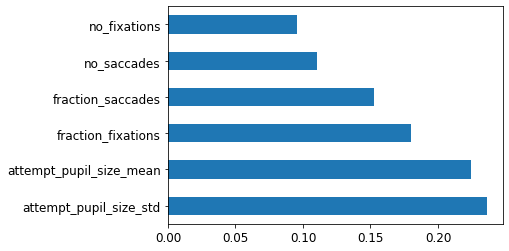

In [22]:
feat_importances = pd.Series(grid_search.best_estimator_.feature_importances_, index=X_test.columns)
feat_importances.nlargest(7).plot(kind='barh')